## Calculate differences
- Calculate differences using different models on the effect of Trauma vs. Sad on amygdala (later hippocampus and vmPFC)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

# regular GLMs
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
## Load amygdala database
df = pd.read_csv('TraumavsNeutral_threeSes.csv')
# create a long format for analysis
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg1','amg2','amg3'])
df_long

,scr_id,groupIdx,variable,value
0,KPE008,1,amg1,0.384864
1,KPE1223,1,amg1,0.072214
2,KPE1253,0,amg1,-0.142767
3,KPE1263,0,amg1,-0.254799
4,KPE1293,1,amg1,-0.054429
...,...,...,...,...
73,KPE1561,0,amg3,0.184200
74,KPE1573,1,amg3,0.391631
75,KPE1578,0,amg3,-0.246893
76,KPE1587,1,amg3,NaN


In [4]:
## Start with simple GLM models (using statsmodel)
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

               Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     value   
No. Observations:       73          Method:                 REML    
No. Groups:             26          Scale:                  0.1034  
Min. group size:        2           Log-Likelihood:         -33.5192
Max. group size:        3           Converged:              Yes     
Mean group size:        2.8                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.092    0.101  0.908 0.364 -0.106  0.290
variable[T.amg2]           0.093    0.129  0.720 0.472 -0.160  0.346
variable[T.amg3]           0.056    0.137  0.407 0.684 -0.213  0.324
groupIdx                  -0.080    0.143 -0.562 0.574 -0.361  0.200
variable[T.amg2]:groupIdx -0.263    0.181 -1.456 0

In [5]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     1.212      1     19  1.212  6.116    0.023  0.244  nan
variable     0.016      2     38  0.008  0.079    0.924  0.004    0.939
Interaction  0.380      2     38  0.190  1.888    0.165  0.090  nan



In [6]:
pg.ttest(df.amg2[df.groupIdx==1], df.amg2[df.groupIdx==0], paired=False, correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.644598,23,two-sided,0.014484,"[-0.62, -0.08]",1.058687,3.918,0.716666


In [7]:
pg.ttest(df.amg1[df.groupIdx==1], df.amg1[df.groupIdx==0], paired=False, correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.520308,24,two-sided,0.607616,"[-0.4, 0.24]",0.204082,0.401,0.079073


In [8]:
pg.ttest(df.amg3[df.groupIdx==1], df.amg3[df.groupIdx==0], correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.904562,20,two-sided,0.071321,"[-0.63, 0.03]",0.815485,1.331,0.441659


### As requested from Reviewer 1 - adding withing group time analysis

In [9]:
### Start with simple GLM models (using statsmodel)
df_longKet = df_long[df_long.groupIdx==1]
glm = smf.mixedlm('value ~ variable', data=df_longKet, groups = df_longKet.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())
aov = pg.rm_anova(data=df_longKet, dv='value', within='variable',
                     subject='scr_id',  effsize="np2")
pg.print_table(aov)

# t test to compare each time to baseline
pg.ttest(df.amg1[df.groupIdx==0], df.amg2[df.groupIdx==0], paired=True, correction=False)


           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  value   
No. Observations:    38       Method:              REML    
No. Groups:          13       Scale:               0.0990  
Min. group size:     2        Log-Likelihood:      -17.6967
Max. group size:     3        Converged:           Yes     
Mean group size:     2.9                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.011    0.104  0.109 0.913 -0.192  0.214
variable[T.amg2] -0.170    0.123 -1.377 0.168 -0.412  0.072
variable[T.amg3] -0.145    0.127 -1.143 0.253 -0.394  0.104
Group Var         0.040    0.122                           


ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2    eps
--------  -------  -------  -----  -------  -----  -----
variable        2       22  1.221    0.3

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.837593,11,two-sided,0.420086,"[-0.42, 0.19]",0.33588,0.387,0.186387


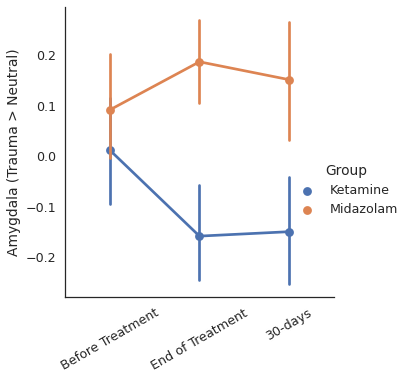

In [9]:
sns.set(font_scale = 1.15)
sns.set_style("white")
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68,
               hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "End of Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala (Trauma > Neutral)")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('amg_pointGraph.png', dpi=300, bbox_inches='tight')

In [22]:
# Bayes
# take indexes for building the model
df_longKet['scr_id'] = df_longKet.scr_id.astype('category')
sub_idx = df_longKet.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_longKet.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_longKet.variable = pd.Categorical(df_longKet.variable, 
                    categories=['amg1','amg2','amg3'])
timeIDX = df_longKet.variable.cat.codes.values
print(timeIDX)
df_longKet['time'] = timeIDX

[ 0  1  2  3  4  5  6  7  8  9 10 11 12  0  1  2  3  4  5  6  7  8  9 10
 11 12  0  1  2  3  4  5  6  7  8  9 10 11 12]
13
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [26]:
with pm.Model() as hierarchical:   
    a = pm.Normal('a', mu=0, sd=0.1, shape=n_subs)
    b = pm.Normal('b', mu=0, sd=0.1, shape=3)
    
    # Model error
    eps = pm.HalfCauchy('eps', 1)

    y_hat = a[sub_idx] + b[timeIDX]

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_longKet.value)
    
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.9, return_inferencedata=True, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [27]:
az.summary(trace, hdi_prob=.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.024,0.092,-0.131,0.168,0.001,0.002,8921.0,2954.0,1.0
a[1],0.007,0.090,-0.142,0.153,0.001,0.001,7607.0,2946.0,1.0
a[2],-0.016,0.090,-0.169,0.131,0.001,0.002,7568.0,3353.0,1.0
a[3],-0.100,0.090,-0.241,0.055,0.001,0.001,7403.0,3135.0,1.0
a[4],0.006,0.091,-0.149,0.152,0.001,0.002,7809.0,2610.0,1.0
a[5],-0.025,0.093,-0.182,0.123,0.001,0.002,8573.0,2432.0,1.0
a[6],-0.118,0.092,-0.271,0.029,0.001,0.001,7351.0,3350.0,1.0
a[7],-0.046,0.092,-0.198,0.098,0.001,0.001,8320.0,3196.0,1.0
a[8],-0.002,0.089,-0.157,0.136,0.001,0.002,7913.0,2598.0,1.0
a[9],0.014,0.090,-0.138,0.159,0.001,0.001,8738.0,2936.0,1.0


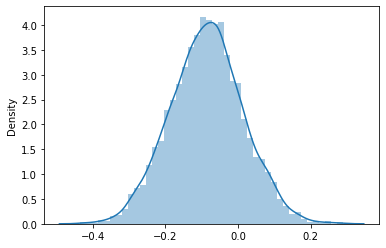

0.18875


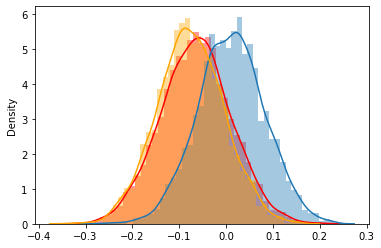

In [36]:
diffTime = trace.posterior['b'].data[:,:,1] - trace.posterior['b'].data[:,:,0]
sns.distplot(diffTime)
plt.show()
sns.distplot(trace.posterior['b'].data[:,:,2], color='red')
sns.distplot(trace.posterior['b'].data[:,:,0])
sns.distplot(trace.posterior['b'].data[:,:,1], color= 'orange')
print(sum(diffTime.ravel()>0)/len(diffTime.ravel()))

## Build a Bayesian model
- Here we would model each subject under each group

In [ ]:
# first lets look at the data
sns.pairplot(df[['amg1','amg2','amg3','groupIdx']], hue='groupIdx', kind='scatter')

In [20]:
df_long.groupby(['groupIdx', 'variable']).describe()

value                                                    \
                  count      mean       std       min       25%       50%   
groupIdx variable                                                           
0        amg1      13.0  0.091727  0.382141 -0.344641 -0.142767 -0.013621   
         amg2      12.0  0.186816  0.296849 -0.292027  0.030829  0.167474   
         amg3      10.0  0.151494  0.383857 -0.246893 -0.155534  0.091739   
1        amg1      13.0  0.011338  0.405330 -0.760030 -0.138400  0.072214   
         amg2      13.0 -0.158637  0.351140 -0.702461 -0.348733 -0.179461   
         amg3      12.0 -0.149890  0.357468 -0.721853 -0.334502 -0.190697   

                                       
                        75%       max  
groupIdx variable                      
0        amg1      0.221137  0.990820  
         amg2      0.287380  0.859317  
         amg3      0.288222  0.906373  
1        amg1      0.316908  0.533188  
         amg2      0.022625  0.433613  
         amg3      0.153811  0.391631

In [ ]:
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68,
               hue_order=[1,0])
g.set_xlabels("Time")
g.set_xticklabels(
    labels=["Before Treatment", "After Treatment", "30-days"], rotation=30)
g.set_xlabels('')
g.set_ylabels("Amygdala (Trauma vs. Neutral)")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('amg_pointGraph.png', dpi=300, bbox_inches = 'tight')

In [ ]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['amg1','amg2','amg3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX


In [ ]:
## Run similar model but without hyperpriors
# now we build a model - modeling the score of each group on each time point
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.1, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.1, shape=4)
    
    
    bMed = pm.Normal('bMed', mu=0, sd=0.1, shape=1) #
  
    # Model error
    eps = pm.HalfCauchy('eps', 1)

    y_hat = a[sub_idx] + b[timeIDX] + bMed*df_long.groupIdx 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(draws=10000, tune=1000, target_accept=0.9, return_inferencedata=True, cores=4)

In [ ]:
az.plot_trace(trace)

In [ ]:
az.summary(trace, hdi_prob=.9)

In [ ]:
diffTime = trace.posterior['b'].data[:,:,2] - trace.posterior['b'].data[:,:,0]
sns.distplot(diffTime)
sum(diffTime.ravel()<0)/len(diffTime.ravel())

## Next we calculate the difference between the groups in each time
- Althgough the interaction wasn't significant, we still look at this one - as there's a group difference

In [10]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.091,0.118,-0.088,0.302,0.003,0.002,1961.0,1985.0,1.0
groupIdx,-0.083,0.165,-0.341,0.202,0.004,0.003,1938.0,2137.0,1.0
sd,0.414,0.065,0.314,0.514,0.001,0.001,2023.0,1832.0,1.0


In [11]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [12]:
az.summary(traceSes2, hdi_prob=.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.191,0.100,0.029,0.356,0.002,0.002,1996.0,2004.0,1.0
groupIdx,-0.353,0.136,-0.576,-0.131,0.003,0.002,1944.0,2176.0,1.0
sd,0.344,0.056,0.257,0.431,0.001,0.001,1748.0,1525.0,1.0


In [13]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [ ]:
az.summary(traceSes3, hdi_prob=.9)

## Using a different method for assessing

In [14]:
## create a function that will simply run the model for each session
def runModel(variable):
    with pm.Model() as hierarchical:
      
        a = pm.Normal('a', mu=0, sd=1) 
        bMed = pm.Normal('bMed', mu=0, sd=1, shape=2) #

        # Model error
        eps = pm.HalfCauchy('eps', 5)

        y_hat = a + bMed[df.groupIdx]

        # Data likelihood
        likelihood = pm.Normal('likelihood', mu=y_hat,
                               sigma=eps, observed=df[str(variable)])

        trace = pm.sample(draws=4000, tune=2000,target_accept=0.9, return_inferencedata=False)
        diff = trace['bMed'][:,1] - trace['bMed'][:,0]
    return trace, diff

In [15]:
ses1trace, ses1Diff = runModel('amg1')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, bMed, a]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 19 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8377664217392475, but should be close to 0.9. Try to increase the number of tuning steps.


Group difference is 0.3110625


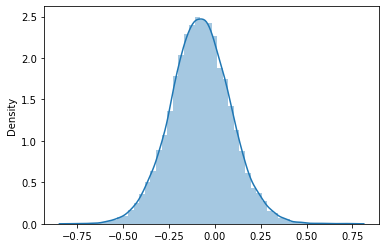

In [16]:
pm.summary(ses1trace)
sns.distplot(ses1Diff)
print(f'Group difference is {sum(ses1Diff>0)/len(ses1Diff)}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, a]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 30 seconds.


Group difference is 0.00875


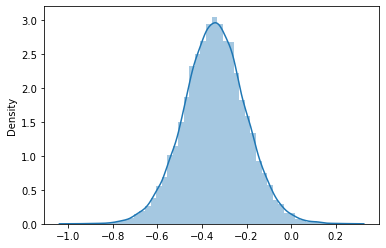

In [17]:
ses2trace, ses2Diff = runModel('amg2')
pm.summary(ses2trace)
sns.distplot(ses2Diff)
print(f'Group difference is {sum(ses2Diff>0)/len(ses2Diff)}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, a]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 29 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Group difference is 0.04125


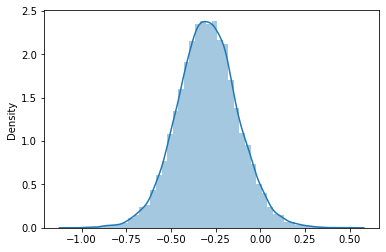

In [18]:
ses3trace, ses3Diff = runModel('amg3')
pm.summary(ses3trace)
sns.distplot(ses3Diff)
print(f'Group difference is {sum(ses3Diff>0)/len(ses3Diff)}')

## Plotting

In [21]:
# set variables
def plotDiff(depVar,indepVar, trace):
    sns.set_style("ticks") # set style
    y = str(depVar)
    dfPlot = df
    ci = np.quantile(trace.posterior[str(indepVar)], [.05,.95])
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(3, 5),gridspec_kw={'width_ratios': [1, .2],
                                                            'wspace':.1})
    g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
    sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
                boxprops=dict(alpha=.3))
    g2 = sns.distplot(trace.posterior[str(indepVar)], ax = ax2, vertical=True)
    ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
               linewidth = 3, linestyle = "-")

    #g3.set_ylim(-.7, .7)
    #ax1.set_ylim(-.7,.7)
    ax2.set_ylim(g1.get_ylim()) # use first graph's limits to get the relevant for this one
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    ax2.set_ylabel("Difference between groups", fontsize=14) 
    ax2.yaxis.set_label_position("right")
    ax1.set_ylabel("Amg reactivity to traumatic script", fontsize=12)
    ax1.set_xlabel("Group", fontsize=14)
   # fig.savefig( str(depVar) + 'Reactivity.png', dpi=300, bbox_inches='tight')
    return fig

In [108]:
def plotSubfigs(subfigs,subNum, depVar,indepVar, trace):
    # gets subfig and the index number of it to plot the same as above
    sns.set_style("ticks") # set style
    y = str(depVar)
    dfPlot = df
    ci = np.quantile(trace.posterior[str(indepVar)], [.05,.95])
    axsLeft = subfigs[subNum].subplots(1,2, gridspec_kw={'width_ratios': [1, .2],'wspace':.01})
    ax1 = axsLeft[0]
    ax2 = axsLeft[1]
    g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
    sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
                 boxprops=dict(alpha=.3))
    g2 = sns.distplot(trace.posterior[str(indepVar)], ax = ax2, vertical=True)
    ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
                linewidth = 3, linestyle = "-")

    ax2.set_ylim(g1.get_ylim()) # use first graph's limits to get the relevant for this one
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    ax2.set_ylabel("Difference between groups", fontsize=14) 
    ax2.yaxis.set_label_position("right")
    ax1.set_ylabel("Amg reactivity to traumatic script", fontsize=12)
    ax1.set_xlabel("Group", fontsize=14)
    

Text(0.5, 0.98, '30-Days')

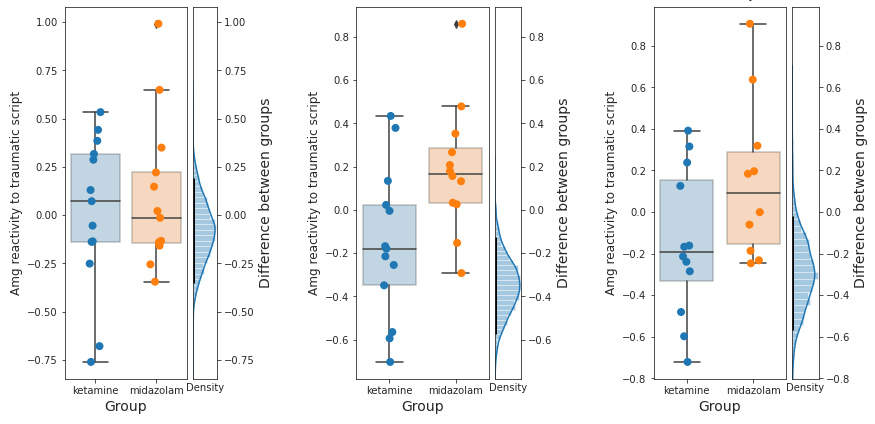

In [113]:
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
subfigs = fig.subfigures(1, 3, wspace=0.1, )
plotSubfigs(subfigs, 0, 'amg1','groupIdx',traceSes1)
subfigs[0].suptitle('Before Treatment', fontsize='large')
plotSubfigs(subfigs, 1, 'amg2','groupIdx',traceSes2)
subfigs[1].suptitle('After Treatment', fontsize='large')
plotSubfigs(subfigs, 2,'amg3','groupIdx',traceSes3)
subfigs[2].suptitle('30-Days', fontsize='large')

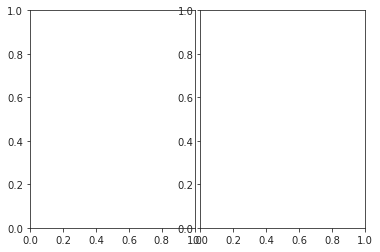

In [114]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(10, 10)
ax00 = plt.subplot(gs[0:,0:5])
ax10 = plt.subplot(gs[0:,5:])
#ax00 = plt.draw(ax1)

In [115]:
pg.ttest(df.amg2[df.groupIdx==1], df.amg2[df.groupIdx==0])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.663025,22.839436,two-sided,0.013943,"[-0.61, -0.08]",1.058687,4.038,0.716666


In [116]:
pg.ttest(df.amg3[df.groupIdx==1], df.amg3[df.groupIdx==0])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.891675,18.712667,two-sided,0.074115,"[-0.64, 0.03]",0.815485,1.31,0.441659
